In [2]:
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/pyprobml_utils.py
!wget -q https://raw.githubusercontent.com/probml/pyprobml/master/scripts/linear_dynamical_systems_lib.py

In [ ]:
import jax.numpy as jnp
import linear_dynamical_systems_lib as lds
import matplotlib.pyplot as plt
import pyprobml_utils as pml
from jax import random

In [5]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [13]:
%config InlineBackend.figure_format = "retina"

In [32]:
def sample_filter_smooth(key, lds_model, n_samples, noisy_init):
    """
    Sample from a linear dynamical system, apply the kalman filter
    (forward pass), and performs smoothing.

    Parameters
    ----------
    lds: LinearDynamicalSystem
        Instance of a linear dynamical system with known parameters

    Returns
    -------
    Dictionary with the following key, values
    * (z_hist) array(n_samples, timesteps, state_size):
        Simulation of Latent states
    * (x_hist) array(n_samples, timesteps, observation_size):
        Simulation of observed states
    * (mu_hist) array(n_samples, timesteps, state_size):
        Filtered means mut
    * (Sigma_hist) array(n_samples, timesteps, state_size, state_size)
        Filtered covariances Sigmat
    * (mu_cond_hist) array(n_samples, timesteps, state_size)
        Filtered conditional means mut|t-1
    * (Sigma_cond_hist) array(n_samples, timesteps, state_size, state_size)
        Filtered conditional covariances Sigmat|t-1
    * (mu_hist_smooth) array(n_samples, timesteps, state_size):
        Smoothed means mut
    * (Sigma_hist_smooth) array(n_samples, timesteps, state_size, state_size)
        Smoothed covariances Sigmat
    """
    z_hist, x_hist = lds_model.sample(key, n_samples, noisy_init)
    mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist = lds_model.kalman_filter(x_hist)
    mu_hist_smooth, Sigma_hist_smooth = lds_model.kalman_smoother(mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist)

    return {
        "z_hist": z_hist,
        "x_hist": x_hist,
        "mu_hist": mu_hist,
        "Sigma_hist": Sigma_hist,
        "mu_cond_hist": mu_cond_hist,
        "Sigma_cond_hist": Sigma_cond_hist,
        "mu_hist_smooth": mu_hist_smooth,
        "Sigma_hist_smooth": Sigma_hist_smooth
    }

def plot_collection(obs, ax, means=None, covs=None, **kwargs):
    if obs.ndim == 2:
        obs = obs[None, ...]
    n_samples, n_steps, _ = obs.shape
    for nsim in range(n_samples):
        X = obs[nsim]
        if means is not None:
            mean = means[nsim]
            ax.scatter(*mean[0, :2], marker="o", s=20, c="black", zorder=2)
            ax.plot(*mean[:, :2].T, marker="o", markersize=2, **kwargs, zorder=1)
            if covs is not None:
                cov = covs[nsim]
                for t in range(1, n_steps, 3):
                    pml.plot_ellipse(cov[t][:2, :2], mean[t, :2], ax,
                    plot_center=False, alpha=0.7)
        ax.scatter(*X.T, marker="+", s=60)


In [78]:
from importlib import reload
reload(lds)

<module 'linear_dynamical_systems_lib' from '/Users/gerardoduran/Documents/repos/msc-dissertation/notebooks/linear_dynamical_systems_lib.py'>

In [140]:
Δ = 1.0
A = jnp.array([
    [1, 0, Δ, 0],
    [0, 1, 0, Δ],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

C = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

state_size, _ = A.shape
observation_size, _ = C.shape

Q = jnp.eye(state_size) * 0.01
R = jnp.eye(observation_size) * 1.2
# Prior parameter distribution
mu0 = jnp.array([8, 10, 1, 0])
Sigma0 = jnp.eye(state_size) * 0.1

n_samples = 4
n_steps = 15

key = random.PRNGKey(3141)
lds_instance = lds.LinearDynamicalSystem(A, C, Q, R, mu0, Sigma0, n_steps)
result = sample_filter_smooth(key, lds_instance, n_samples, True)

Sigma_cond_hist = result["Sigma_cond_hist"][1]
for Sigman_cond in Sigma_cond_hist:
    St = lds_instance.C @ Sigman_cond @ lds_instance.C.T + lds_instance.R
    Kn = Sigman_cond @ lds_instance.C.T @ jnp.linalg.inv(St)
    k_area = jnp.sqrt(jnp.linalg.det(Kn @ Kn.T))
    print((jnp.eye(4) - Kn @ C)[:2, :2])

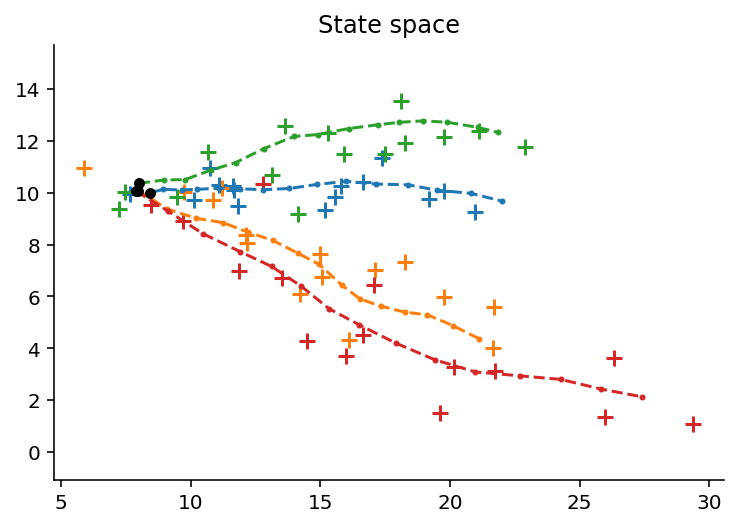

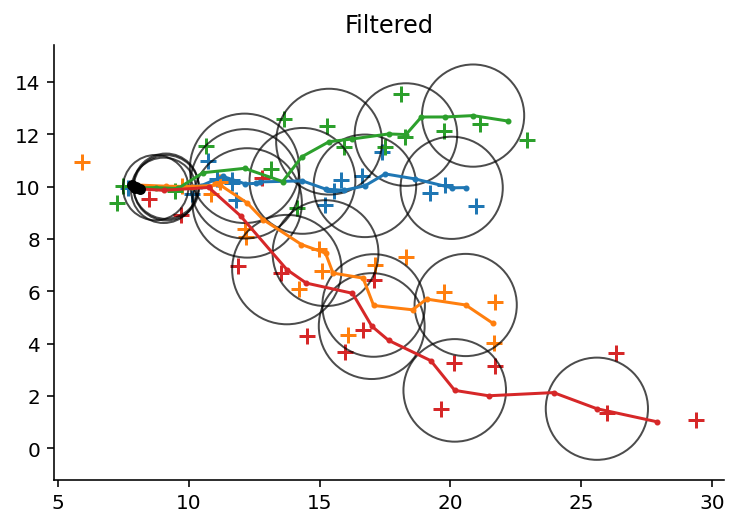

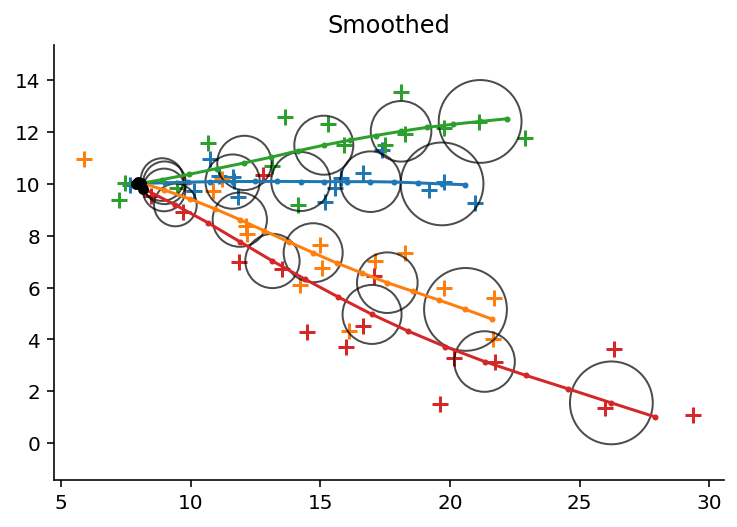

In [141]:
fig, ax = plt.subplots()
plot_collection(result["x_hist"], ax, result["z_hist"], linestyle="--")
ax.set_title("State space")
plt.axis("equal")
# pml.savefig("missiles_latent.pdf")

fig, ax = plt.subplots()
plot_collection(result["x_hist"], ax, result["mu_hist"], result["Sigma_hist"])
ax.set_title("Filtered")
plt.axis("equal")
# pml.savefig("missiles_filtered.pdf")

fig, ax = plt.subplots()
plot_collection(result["x_hist"], ax, result["mu_hist_smooth"], result["Sigma_hist_smooth"])
ax.set_title("Smoothed")
plt.axis("equal")
# pml.savefig("missiles_smoothed.pdf")

plt.show()